In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fftpack import fft

# 1. Reading data
file_path = r'F:\manchester\apply\project\dataset\merged_dataset.csv'
df = pd.read_csv(file_path)


In [2]:
# 2. Data checking
def check_data(df):
    print("\ndata basic information：")
    print(df.info())
    print("\nStatistics of missing data values：")
    print(df.isnull().sum())
    print("\nData descriptive statistical information：")
    print(df.describe())

check_data(df)


data basic information：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212577 entries, 0 to 212576
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   TIME               212577 non-null  float64
 1   P1                 212577 non-null  float64
 2   P2                 212577 non-null  float64
 3   P3                 212577 non-null  float64
 4   P4                 212577 non-null  float64
 5   P5                 212577 non-null  float64
 6   P6                 212577 non-null  float64
 7   P7                 212577 non-null  float64
 8   Case#              212577 non-null  int64  
 9   Spacecraft#        212577 non-null  int64  
 10  Condition          212577 non-null  object 
 11  Opening_Ratio_SV1  212577 non-null  int64  
 12  Opening_Ratio_SV2  212577 non-null  int64  
 13  Opening_Ratio_SV3  212577 non-null  int64  
 14  Opening_Ratio_SV4  212577 non-null  int64  
 15  Bubble_BP1         212577 

In [3]:
#Creation of classification target columns
df["is_abnormal"] = df["Condition"].apply(lambda x: 1 if x == "abnormal" else 0)
df["fault_type"] = df[["Bubble_BP1", "Bubble_BP2", "Bubble_BP3", "Bubble_BP4",
                       "Bubble_BP5", "Bubble_BP6", "Bubble_BP7", "Bubble_BV1"]].sum(axis=1)
df["solenoid_fault"] = df[["Opening_Ratio_SV1", "Opening_Ratio_SV2", "Opening_Ratio_SV3", "Opening_Ratio_SV4"]].sum(axis=1)


In [4]:
# 4. Statistical feature extraction（P1 - P7）
pressure_cols = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7']
stats_features = df.groupby("Case#")[pressure_cols].agg(['mean', 'std', 'min', 'max', 'median'])
stats_features.columns = ["_".join(col) for col in stats_features.columns]
stats_features.reset_index(inplace=True)

In [5]:
# 5. Time series characterization (calculation of the rate of pressure change)
for col in pressure_cols:
    df[f"{col}_diff"] = df.groupby("Case#")[col].diff().fillna(0)

time_series_features = df.groupby("Case#")[['P1_diff', 'P2_diff', 'P3_diff', 'P4_diff', 'P5_diff', 'P6_diff', 'P7_diff']].agg(['mean', 'std'])
time_series_features.columns = ["_".join(col) for col in time_series_features.columns]
time_series_features.reset_index(inplace=True)

In [8]:
# 6. Frequency-domain features (FFT extraction)
def extract_fft_features(df, col):
    fft_vals = np.abs(fft(df[col].values))  # Calculate FFT amplitude
    return pd.Series({
        f"{col}_fft_mean": np.mean(fft_vals),
        f"{col}_fft_max": np.max(fft_vals),
        f"{col}_fft_std": np.std(fft_vals)
    })

fft_features = df.groupby("Case#").apply(lambda x: extract_fft_features(x, "P1"))
fft_features.reset_index(inplace=True)


In [9]:
for case in df["Case#"].unique()[:5]:
    print(f"Case {case}  P1 Sensor Data Description:")
    print(df[df["Case#"] == case]["P1"].describe())


Case 1  P1 Sensor Data Description:
count    1201.000000
mean        1.984867
std         0.308519
min         0.436248
25%         1.893564
50%         1.956786
75%         2.059497
max         4.228663
Name: P1, dtype: float64
Case 2  P1 Sensor Data Description:
count    1201.000000
mean        1.984931
std         0.308624
min         0.436435
25%         1.893815
50%         1.957459
75%         2.058403
max         4.256737
Name: P1, dtype: float64
Case 3  P1 Sensor Data Description:
count    1201.000000
mean        1.984999
std         0.308539
min         0.436793
25%         1.892870
50%         1.960032
75%         2.058726
max         4.295627
Name: P1, dtype: float64
Case 4  P1 Sensor Data Description:
count    1201.000000
mean        1.984965
std         0.308392
min         0.437050
25%         1.893398
50%         1.958703
75%         2.058818
max         4.295622
Name: P1, dtype: float64
Case 5  P1 Sensor Data Description:
count    1201.000000
mean        1.984987
std   

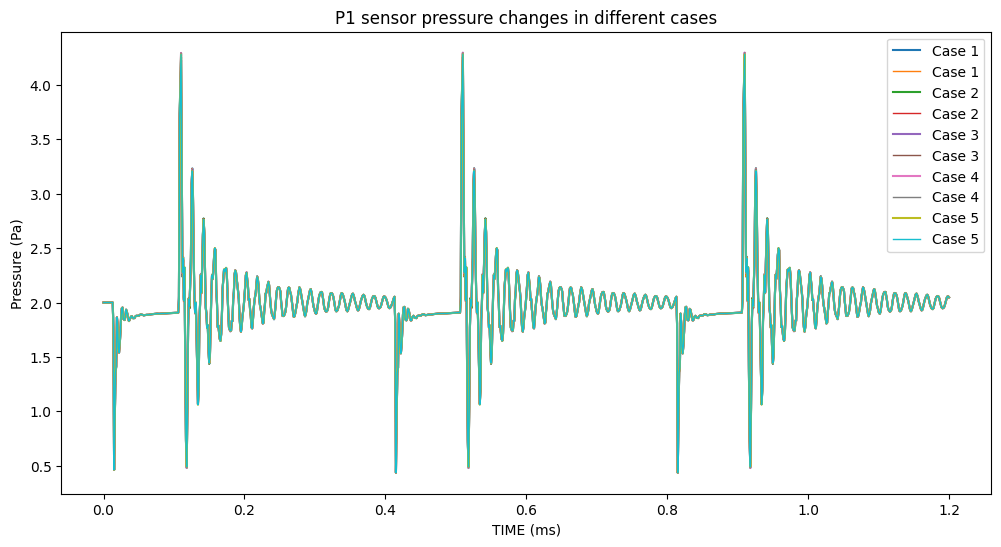

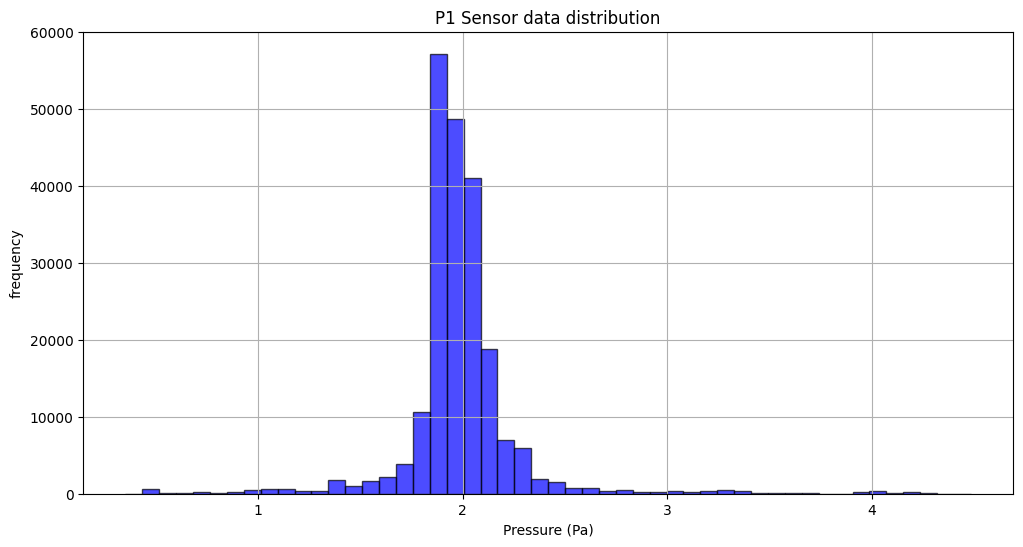

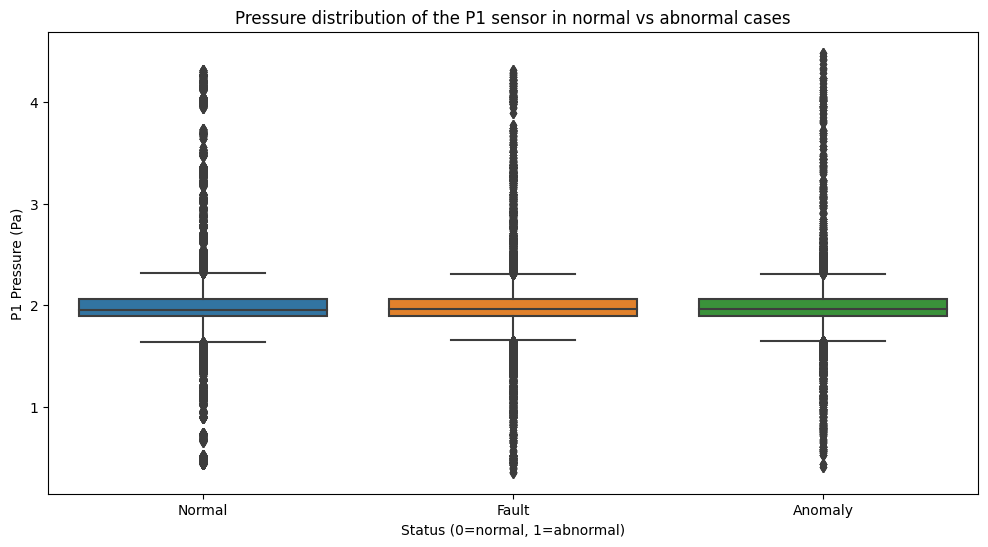

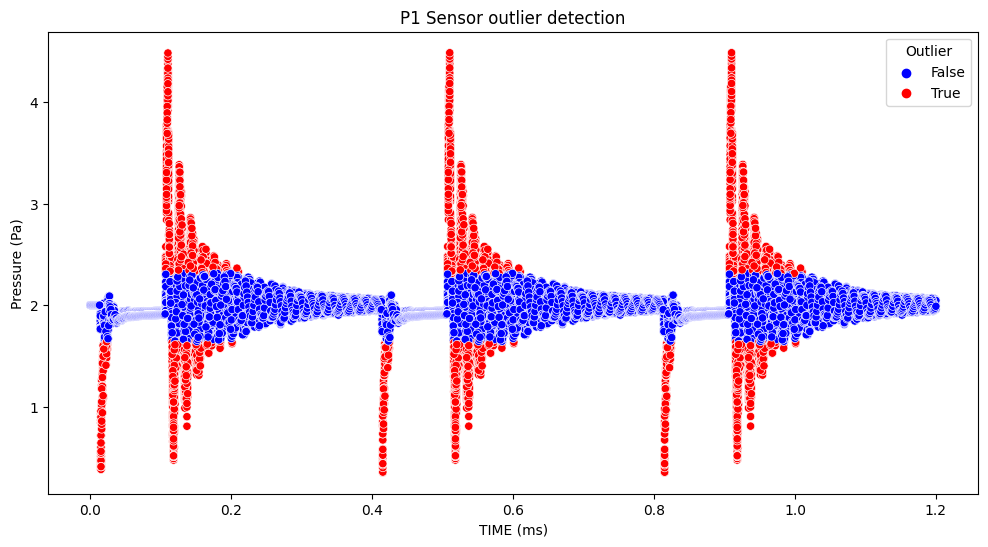

In [10]:
# 7. visual analysis
# Time series trends
plt.figure(figsize=(12,6))
for case in df["Case#"].unique()[:5]:
    subset = df[df["Case#"] == case]
    plt.plot(subset["TIME"], subset["P1"], label=f"Case {case}")
    plt.plot(subset["TIME"], subset["P1"], label=f"Case {case}", linewidth=1)  # Thinning lines
plt.title("P1 sensor pressure changes in different cases")
plt.xlabel("TIME (ms)")
plt.ylabel("Pressure (Pa)")
plt.legend()
plt.show()

# distribution histogram
plt.figure(figsize=(12,6))
df["P1"].hist(bins=50, alpha=0.7, color='blue', edgecolor='black')
plt.title("P1 Sensor data distribution")
plt.xlabel("Pressure (Pa)")
plt.ylabel("frequency")
plt.show()

# box plot (math.)
plt.figure(figsize=(12,6))
sns.boxplot(x="Condition", y="P1", data=df)
plt.title("Pressure distribution of the P1 sensor in normal vs abnormal cases")
plt.xlabel("Status (0=normal, 1=abnormal)")
plt.ylabel("P1 Pressure (Pa)")
plt.show()

# Anomaly Detection Visualization (IQR based)
def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data[column] < lower_bound) | (data[column] > upper_bound)

df["Outlier"] = detect_outliers(df, "P1")
plt.figure(figsize=(12,6))
sns.scatterplot(x=df["TIME"], y=df["P1"], hue=df["Outlier"], palette={False: 'blue', True: 'red'})
plt.title("P1 Sensor outlier detection")
plt.xlabel("TIME (ms)")
plt.ylabel("Pressure (Pa)")
plt.show()



No Bubble     183753
Bubble_BP1      3603
Bubble_BP2      3603
Bubble_BP3      3603
Bubble_BP4      3603
Bubble_BP5      3603
Bubble_BP6      3603
Bubble_BP7      3603
Bubble_BV1      3603
Name: fault_type, dtype: int64


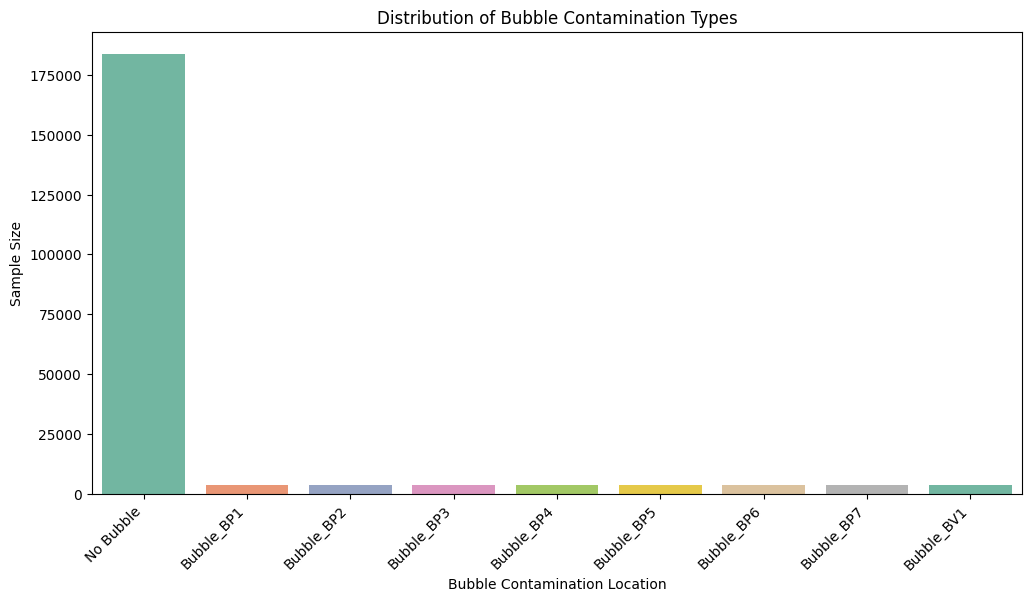

In [11]:
# Define the bubble pollution column name first
bubble_cols = ["Bubble_BP1", "Bubble_BP2", "Bubble_BP3", "Bubble_BP4",
               "Bubble_BP5", "Bubble_BP6", "Bubble_BP7", "Bubble_BV1"]

# Ensure that the column names in the data are correct
for col in bubble_cols:
    if col not in df.columns:
        print(f"Warning: {col} not found in dataframe!")

# Convert “Yes”/“No” to 1/0 first.
df[bubble_cols] = df[bubble_cols].applymap(lambda x: 1 if x == "Yes" else 0)

# Combining multiple bubble contamination locations
df["fault_type"] = df[bubble_cols].apply(lambda row: ", ".join([col for col in bubble_cols if row[col] == 1]), axis=1)

# If there is no bubble contamination, it is labeled “No Bubble”
df["fault_type"] = df["fault_type"].replace("", "No Bubble")

# Statistics on the number of different pollution types
print(df["fault_type"].value_counts())

# Mapping the location of bubble contamination
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.countplot(x="fault_type", data=df, palette="Set2", order=df["fault_type"].value_counts().index)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels to prevent overlap
plt.title("Distribution of Bubble Contamination Types")
plt.xlabel("Bubble Contamination Location")
plt.ylabel("Sample Size")
plt.show()

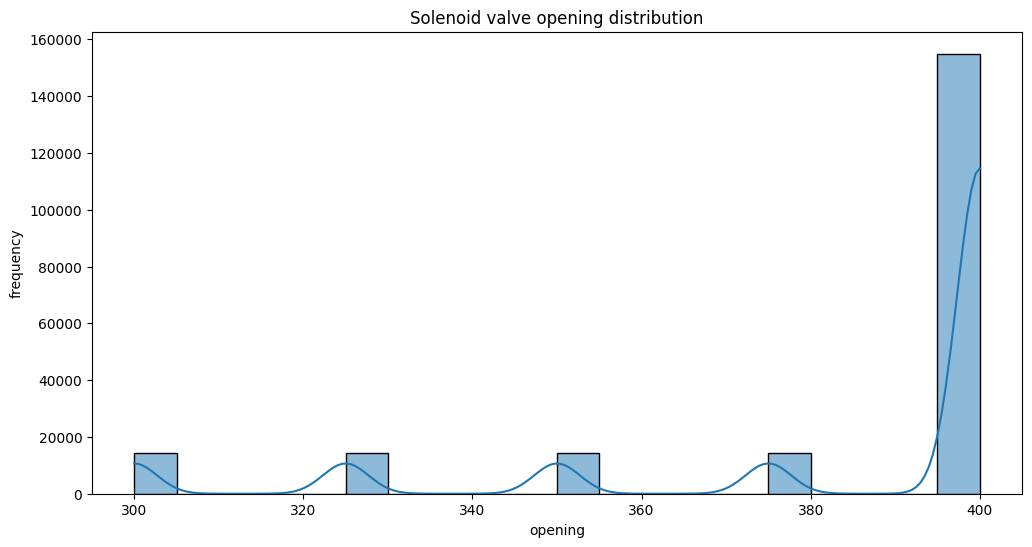

In [12]:
# Solenoid valve opening prediction analysis
plt.figure(figsize=(12,6))
sns.histplot(df["solenoid_fault"], bins=20, kde=True)
plt.title("Solenoid valve opening distribution")
plt.xlabel("opening")
plt.ylabel("frequency")
plt.show()


In [13]:
# 8. Combine all features
total_features = stats_features.merge(time_series_features, on="Case#").merge(fft_features, on="Case#")

# 9. Save final feature data
total_features.to_csv(r'F:\manchester\apply\project\dataset\final_features.csv', index=False)

print("Final characterization data saved！")

Final characterization data saved！


In [14]:
subset

,TIME,P1,P2,P3,P4,P5,P6,P7,Case#,Spacecraft#,...,is_abnormal,fault_type,solenoid_fault,P1_diff,P2_diff,P3_diff,P4_diff,P5_diff,P6_diff,P7_diff
4804,0.000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,5,1,...,0,NoNoNoNoNoNoNoNo,400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4805,0.001,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,5,1,...,0,NoNoNoNoNoNoNoNo,400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4806,0.002,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,5,1,...,0,NoNoNoNoNoNoNoNo,400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4807,0.003,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,5,1,...,0,NoNoNoNoNoNoNoNo,400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4808,0.004,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,5,1,...,0,NoNoNoNoNoNoNoNo,400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6000,1.196,2.026582,2.038562,2.042673,2.044145,2.044266,2.050091,2.038876,5,1,...,0,NoNoNoNoNoNoNoNo,400,0.027517,0.036755,0.040898,0.039724,0.042740,0.040203,0.035719
6001,1.197,2.047255,2.072278,2.075619,2.076874,2.073273,2.087463,2.075643,5,1,...,0,NoNoNoNoNoNoNoNo,400,0.020673,0.033716,0.032947,0.032728,0.029007,0.037372,0.036767
6002,1.198,2.056132,2.089030,2.100418,2.105977,2.096413,2.114337,2.098064,5,1,...,0,NoNoNoNoNoNoNoNo,400,0.008877,0.016752,0.024798,0.029103,0.023140,0.026874,0.022421
6003,1.199,2.055404,2.096298,2.103538,2.112034,2.098353,2.113145,2.112562,5,1,...,0,NoNoNoNoNoNoNoNo,400,-0.000728,0.007268,0.003120,0.006058,0.001940,-0.001192,0.014498
